In [300]:
# Important necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from matplotlib.lines import Line2D
from tqdm import *
from itertools import compress
from scipy.optimize import bisect
import math
%matplotlib inline  

In [301]:
def round_sigfigs(num, sig_figs):
    """Round to specified number of sigfigs.

    >>> round_sigfigs(0, sig_figs=4)
    0
    >>> int(round_sigfigs(12345, sig_figs=2))
    12000
    >>> int(round_sigfigs(-12345, sig_figs=2))
    -12000
    >>> int(round_sigfigs(1, sig_figs=2))
    1
    >>> '{0:.3}'.format(round_sigfigs(3.1415, sig_figs=2))
    '3.1'
    >>> '{0:.3}'.format(round_sigfigs(-3.1415, sig_figs=2))
    '-3.1'
    >>> '{0:.5}'.format(round_sigfigs(0.00098765, sig_figs=2))
    '0.00099'
    >>> '{0:.6}'.format(round_sigfigs(0.00098765, sig_figs=3))
    '0.000988'
    """
    if num != 0:
        return round(num, -int(math.floor(math.log10(abs(num))) - (sig_figs - 1)))
    else:
        return 0  # Can't take the log of 0


In [302]:
def combine_background_files(folder='../data/bkg_Zj/', lumi=37*1000, nfiles=200, cut=None,extra='', return_cxn = False, kf=1.0):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(extra)+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(extra)+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    mean_cxn  = np.mean([meta_frame['cxn'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]*5000*kf
        
    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    if return_cxn:
        return data, mean_cxn
    else:
        return data

In [303]:
def to_str(num):
    if .2 <= num <= .9:
        return '{:.1g}'.format(num)[-2:]
    elif num == 0:
        return '0.0'
    elif num == 0.99:
        return '0.99'
    elif num == 1:
        return '1.0'
    else:
        return str(num)

def combine_signal_files(folder='../data/bkg_Zj/', mphi = 1700, rinv = 1, lumi=37*1000, nfiles=2, cut = None,extra='', return_cxn = False):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(extra)+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    mean_cxn  = np.mean([meta_frame['cxn'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]


        
    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    if return_cxn:
        return data, mean_cxn
    else:
        return data

In [304]:
plot_colors = ['cornflowerblue','firebrick']

# $M_{jj}$ search

In [305]:
Zj_df = combine_background_files('../data/bkg_Zj/', nfiles=1000,kf=1.1)
Wj_df = combine_background_files('../data/bkg_Wj/', nfiles=1000,kf=1.)
tt_d_df = combine_background_files('../data/bkg_ttbar_dilep//', nfiles=1000,kf=1.7)
tt_s_df = combine_background_files('../data/bkg_ttbar_semilep//', nfiles=1000,kf=1.7)
QCD_df = combine_background_files('../data/bkg_qcd////', nfiles=2000,kf=1.0)

tt_df = pd.concat([tt_d_df, tt_s_df])

In [306]:
def limit(sig,bkg):
    if np.sum(sig)==0:
        return 1e99
    def func_root(x):
        part1 = bkg > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg[part1]
        qcd_2 = bkg[part2]
        sig_1 = sig[part1]
        sig_2 = sig[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1+0.02**2*qcd_1**2))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 2
        return my_val
    
    
    soln = bisect(func_root, -10.,20.)
    return 10**soln

In [307]:
bkgs = [Zj_df, Wj_df, tt_df, QCD_df]

In [308]:
def get_bkg(bkg, cut=None):
    if cut not in [None,'']:
        new_bkg = bkg.query(cut)
    else: 
        new_bkg = bkg
    return np.sum(np.histogram(new_bkg['MEt'].values, weights=new_bkg['weight'].values)[0])

def get_sig(sig, cut=None):
    if cut not in [None,'']:
        new_bkg = sig.query(cut)
    else: 
        new_bkg = sig
    return np.sum(np.histogram(new_bkg['MEt'].values, weights=new_bkg['weight'].values)[0])

In [309]:
benchmarks = [[0., 1500], [0.3, 1500]]

In [310]:
cuts = ['' for i in range(2)]
trigger_presel = 'pt1 > 440 & pt2 > 60'
cuts[0] = ''
cuts[1] = ' & 1.2 > y1-y2 > -1.2'

for i in range(1,2):
    cuts[i] += cuts[i-1]
    
# cuts[5] += cuts[3]

In [311]:
bkg_cutflow = [[round_sigfigs(get_bkg(bkg, trigger_presel + cut),3) for bkg in bkgs] for cut in cuts]
sigs = [combine_signal_files('../data/sig_zprime/', mass, rinv, extra = '' , nfiles=4, return_cxn=True)[0] for rinv, mass  in benchmarks]
cxns = [combine_signal_files('../data/sig_zprime/', mass, rinv, extra = '' , nfiles=4, return_cxn=True)[1] for rinv, mass in benchmarks]

In [312]:
sig_cutflow = [[round_sigfigs(get_sig(sig,trigger_presel + cut),3) for sig, cxn in zip(sigs, cxns)] for cut in cuts]

In [313]:
bk_sum = np.sum(bkg_cutflow, axis = 1)

In [314]:
def signif(s, b ):
    return s/np.sqrt(s+b)

In [315]:
sig_sigs = [[round(signif(sig_cutflow[i][j],bk_sum[i]),2) for i in range(len(cuts))] for j in range(len(benchmarks))]

In [316]:
for i in range(len(cuts)):
    for j in range(len(benchmarks)):
        sig_cutflow[i][j] = str(int(sig_cutflow[i][j]) )+"("+str(np.transpose(sig_sigs)[i][j])+")"

In [317]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow))
bkg_cutflow_pd = pd.DataFrame(np.array(bkg_cutflow).astype(np.int32))

In [318]:
bkg_cutflow_pd['4'] = pd.Series(bk_sum, index=bkg_cutflow_pd.index).astype(np.int32)

In [319]:
print pd.concat([sig_cutflow_pd, bkg_cutflow_pd], axis = 1).to_latex()

\begin{tabular}{lllrrrrr}
\toprule
{} &           0 &           1 &      0 &       1 &      2 &         3 &         4 \\
\midrule
0 &   9860(1.8) &  6770(1.23) &  70900 &  143000 &  54100 &  29800000 &  30068000 \\
1 &  6630(1.62) &  5060(1.24) &  41100 &   83200 &  36700 &  16500000 &  16661000 \\
\bottomrule
\end{tabular}



In [320]:
bkg_sum = pd.concat(bkgs)

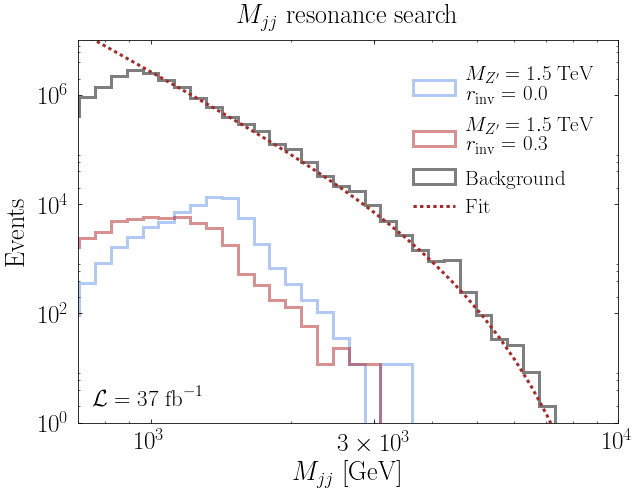

In [324]:
fig=plt.figure(figsize=(9,7))




sig_cuts = [sig.query(trigger_presel + cuts[-1]) for sig in sigs]
bkg_cut = bkg_sum.query(trigger_presel + cuts[-1])
for isig, sig_cut in enumerate(sig_cuts):
    plt.hist(sig_cut['mjj'], weights=10*sig_cut['weight'].values, histtype='step', bins = np.logspace(2,4,60), lw= 3, alpha=0.5, label = "$M_{Z^\prime} = 1.5$ TeV\n$r_\mathrm{inv}$ = " + str(benchmarks[isig][0]), color=plot_colors[isig])
#     plt.hist(sig_cut['mjj'], weights=10*sig_cut['weight'].values, histtype='step', bins = np.logspace(2,4,60), lw= 3, alpha=0.5, label = "$M_{Z^\prime} = 1.5$ TeV\n$r_\mathrm{inv}$ = " + str(benchmarks[isig][0]), color=plot_colors[isig])
plt.hist(bkg_cut['mjj'], weights=bkg_cut['weight'].values, histtype='step', bins = np.logspace(2,4,60), lw=3, alpha=0.5, color='black', label="Background")

# tim's code
# QCD dijet background
def qcd(x):
    bw=1.15/((8000.-100.)/90.)
    z=x/13000.
    return bw*10**(2.81271 - 1.06475*np.log(z) + 0.199172* (np.log(z))**2 + 5.46329*np.log(1 - z))
    
bins= np.logspace(2,4,60)
bc = np.sqrt(bins[1:]*bins[:-1])
bw = (bins[1:]-bins[:-1])
plt.plot(bc, qcd(bc)*bw,lw=3,ls=':',c='brown', label='Fit')
# tim's code

plt.yscale("log")
plt.xscale("log")
plt.gca().set_xscale("log")
plt.xlim(700,10000)
plt.ylabel("Events", fontsize=26)
plt.xlabel("$M_{jj}$ [GeV]", fontsize=26)
plt.ylim(1,1e7)
handles,labels = ax.get_legend_handles_labels()
handles = handles[1:] + [handles[0]]
labels = labels[1:] + [labels[0]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=21, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0., loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([10**3,3*10**3,10**4],["$10^3$","$3 \\times 10^3$","$10^4$"])
plt.title("$M_{jj}$ resonance search", fontsize=26)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])
plt.text(750,2,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=23)
plt.tight_layout()
plt.savefig("ResSearch.pdf")

In [285]:
Zj_df = combine_background_files('../data/bkg_Zj/', nfiles=1000,kf=1.1, extra='reclustered_')
Wj_df = combine_background_files('../data/bkg_Wj/', nfiles=1000,kf=1., extra='reclustered_')
tt_d_df = combine_background_files('../data/bkg_ttbar_dilep//', nfiles=1000,kf=1.7, extra='reclustered_')
tt_s_df = combine_background_files('../data/bkg_ttbar_semilep//', nfiles=1000,kf=1.7, extra='reclustered_')
QCD_df = combine_background_files('../data/bkg_qcd////', nfiles=2000,kf=1.0, extra='reclustered_')

tt_df = pd.concat([tt_d_df, tt_s_df])

In [286]:
bkgs = [Zj_df, Wj_df, tt_df, QCD_df]

# $M_T$ search

In [287]:
benchmarks = [[0.1, 2000], [0.5, 2000]]

In [288]:
cuts = ['' for i in range(4)]
trigger_presel = 'pt2> 100 & MEt > 200'
cuts[0] = ''
cuts[1] = ' & MEt > .15*Mt'
cuts[2] = ' & 1.1 > eta1-eta2 > -1.1'
cuts[3] = ' & dphi < 0.4'


for i in range(1,4):
    cuts[i] += cuts[i-1]
    
# cuts[5] += cuts[3]

In [289]:
bkg_cutflow = [[round_sigfigs(get_bkg(bkg, trigger_presel + cut),3) for bkg in bkgs] for cut in cuts]
sigs = [combine_signal_files('../data/sig_zprime/', mass, rinv, extra = 'reclustered_' , nfiles=4, return_cxn=True)[0] for rinv, mass  in benchmarks]
cxns = [combine_signal_files('../data/sig_zprime/', mass, rinv, extra = 'reclustered_' , nfiles=4, return_cxn=True)[1] for rinv, mass in benchmarks]

In [290]:
sig_cutflow = [[round_sigfigs(get_sig(sig,trigger_presel + cut),3) for sig, cxn in zip(sigs, cxns)] for cut in cuts]

In [291]:
bk_sum = np.sum(bkg_cutflow, axis = 1)

In [292]:
sig_sigs = [[round(signif(sig_cutflow[i][j],bk_sum[i]),2) for i in range(len(cuts))] for j in range(len(benchmarks))]

In [293]:
for i in range(len(cuts)):
    for j in range(len(benchmarks)):
        sig_cutflow[i][j] = str(int(sig_cutflow[i][j]) )+"("+str(np.transpose(sig_sigs)[i][j])+")"

In [294]:
sig_cutflow_pd = pd.DataFrame(np.array(sig_cutflow))
bkg_cutflow_pd = pd.DataFrame(np.array(bkg_cutflow).astype(np.int32))

In [295]:
bkg_cutflow_pd['4'] = pd.Series(bk_sum, index=bkg_cutflow_pd.index).astype(np.int32)

In [296]:
print pd.concat([sig_cutflow_pd, bkg_cutflow_pd], axis = 1).to_latex()

\begin{tabular}{lllrrrrr}
\toprule
{} &          0 &           1 &       0 &       1 &      2 &      3 &       4 \\
\midrule
0 &  634(1.03) &   1360(2.2) &  108000 &  141000 &  68100 &  64400 &  381500 \\
1 &  403(0.69) &  1250(2.13) &  102000 &  131000 &  63700 &  46300 &  343000 \\
2 &  250(0.58) &   756(1.75) &   51700 &   71200 &  38900 &  24900 &  186700 \\
3 &  239(0.79) &   637(2.11) &   11100 &   33400 &  21800 &  24300 &   90600 \\
\bottomrule
\end{tabular}



In [297]:
plot_colors = ['cornflowerblue','firebrick']

In [298]:
bkg_sum = pd.concat(bkgs)

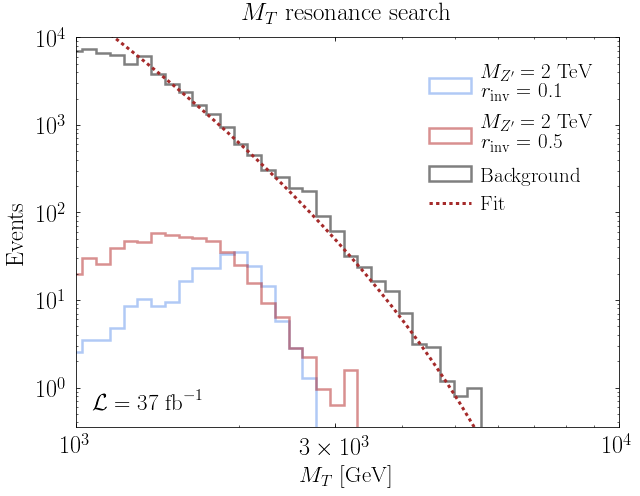

In [299]:
fig=plt.figure(figsize=(9,7))
sig_cuts = [sig.query(trigger_presel + cuts[-1]) for sig in sigs]
bkg_cut = bkg_sum.query(trigger_presel + cuts[-1])
for isig, sig_cut in enumerate(sig_cuts):
    plt.hist(sig_cut['Mt'], weights=sig_cut['weight'].values, histtype='step', bins = np.logspace(2,4,80), lw= 2.5, alpha=0.5, label = "$M_{Z^\prime} = 2$ TeV\n$ r_\mathrm{inv}$ = " + str(benchmarks[isig][0]), color=plot_colors[isig])
    sig_plus_bkg = pd.concat([sig_cut, bkg_cut])    
#     plt.hist(sig_plus_bkg['Mt'], weights=sig_plus_bkg['weight'], histtype='step', bins = np.linspace(100,8000,100), lw=2.5, alpha=0.5, color=plot_colors[isig])
plt.hist(bkg_cut['Mt'], weights=bkg_cut['weight'].values, histtype='step', bins = np.logspace(2,4,80), lw=2.5, alpha=0.5, color='black', label="Background")


# tim code
def qcd(x_):
    x=(x_[:-1]+x_[1:])/2.
    bw=(x_[1:]-x_[:-1])
    z=x/13000.
    return 1.1*bw*np.exp( -8.52204 -6.50915*np.log(z) -0.278056*(np.log(z))**2 + 
                   6.39077*np.log(1 - z) - 1.35113*(np.log(1 - z))**2 )

bins = np.logspace(2,4,80)
bc = np.sqrt(bins[1:]*bins[:-1])
bw = (bins[1:]-bins[:-1])
plt.plot(bc, qcd(bins),lw=3,ls=':',c='brown', label='Fit')

# tim code

plt.yscale("log")
plt.xscale("log")
plt.gca().set_xscale("log")
plt.xlim(1000,10000)
plt.ylabel("Events", fontsize=24)
plt.xlabel("$M_{T}$ [GeV]", fontsize=23)
plt.ylim(0.35,10**4)
ax = plt.gca()
handles,labels = ax.get_legend_handles_labels()

handles = handles[1:] + [handles[0]]
labels = labels[1:] + [labels[0]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=21, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0., loc='upper right')

plt.tick_params(axis='both', which='major', labelsize=24)
plt.title("$M_T$ resonance search", fontsize=25)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])
plt.xticks([10**3,3*10**3,10**4],["$10^3$","$3 \\times 10^3$","$10^4$"])
plt.text(1070,0.55,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=23)
plt.tight_layout()
plt.savefig("MTSearch.pdf")
plt.show()